### 1. 라이브러리 선언

In [ ]:
import tensorflow as tf

from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from cv2 import imread,imshow,resize
import re
import math


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

> ### 2. CSV파일 불러오기

In [ ]:
webtoon=pd.read_csv('/content/drive/MyDrive/dataset/WebtoonImg/weekWebtoon.csv')

In [ ]:
webtoon.columns = ['웹툰이름', '썸네일경로', '웹툰디테일경로']

- 샘플이미지 확인

(623, 480, 3)


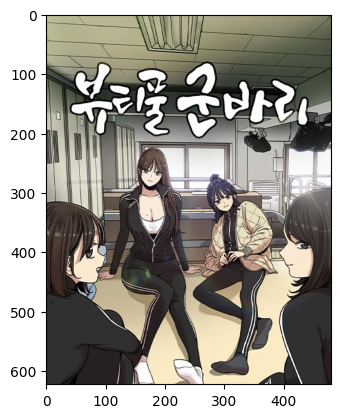

In [ ]:
import urllib.request
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


headers={'User-Agent': 'Mozilla/5.0'}

file_img = webtoon['썸네일경로'][0]
req = urllib.request.Request(file_img, headers=headers)
f = urllib.request.urlopen(req)
image_data = np.array(Image.open(f))

print(image_data.shape)

plt.imshow(image_data)
plt.show()

> ### 3. 이미지 전처리

In [ ]:
IMG_HEIGHT =  224
IMG_WIDTH = 224
IMG_CHANNELS = 3

train = np.zeros((len(webtoon), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)


In [ ]:
pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt



In [ ]:
train_tuples=list(zip(webtoon['썸네일경로'] , webtoon['웹툰이름']))

- 224 x 224로 resizing

In [ ]:
headers={'User-Agent': 'Mozilla/5.0'}
for i, image_r in enumerate(webtoon['썸네일경로']):



  file_img = image_r
  req = urllib.request.Request(file_img, headers=headers)
  f = urllib.request.urlopen(req)
  image_data = np.array(Image.open(f))

  image = resize(image_data, (IMG_HEIGHT, IMG_WIDTH))
  train[i] = image

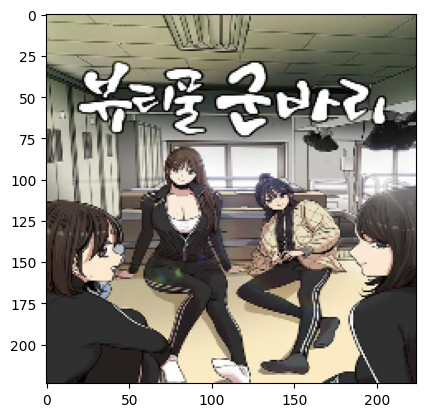

In [ ]:
plt.imshow(train[0])

> ### 4. 모델링
ResNet

In [ ]:
import torch
from torchvision import models


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url
from torch.autograd import Variable
from PIL import Image

In [ ]:
from matplotlib.transforms import Transform



model = models.resnet18(pretrained=True) # 사전학습모델 불러오기


layer = model._modules.get('avgpool') # avgpool 계층


model.eval()


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vector(image):



    t_img = Variable(normalize(to_tensor(image)).unsqueeze(0))


    my_embedding = torch.zeros(512)

    def copy_data(m, i, o):

      my_embedding.copy_(o.data.reshape(o.data.size(1)))

    h = layer.register_forward_hook(copy_data)

    model(t_img)

    h.remove()

    return my_embedding.numpy()

In [ ]:


base_dir = '/content/drive/MyDrive/dataset/WebtoonImg/sampleImg'

features =[]

for i in range(len(train)):
  #img_dir = base_dir + str(i)+".jpg";
  features.append(get_vector(train[i]))



In [ ]:
nd_features=np.array(features)

In [ ]:
nd_features.shape

(431, 512)

### 5. 차원축소 및 군집화

- T-SNE ( perplexity : 40)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42,perplexity=40)

features_tsne = tsne.fit_transform(nd_features)

In [ ]:
features_tsne.shape

(431, 2)

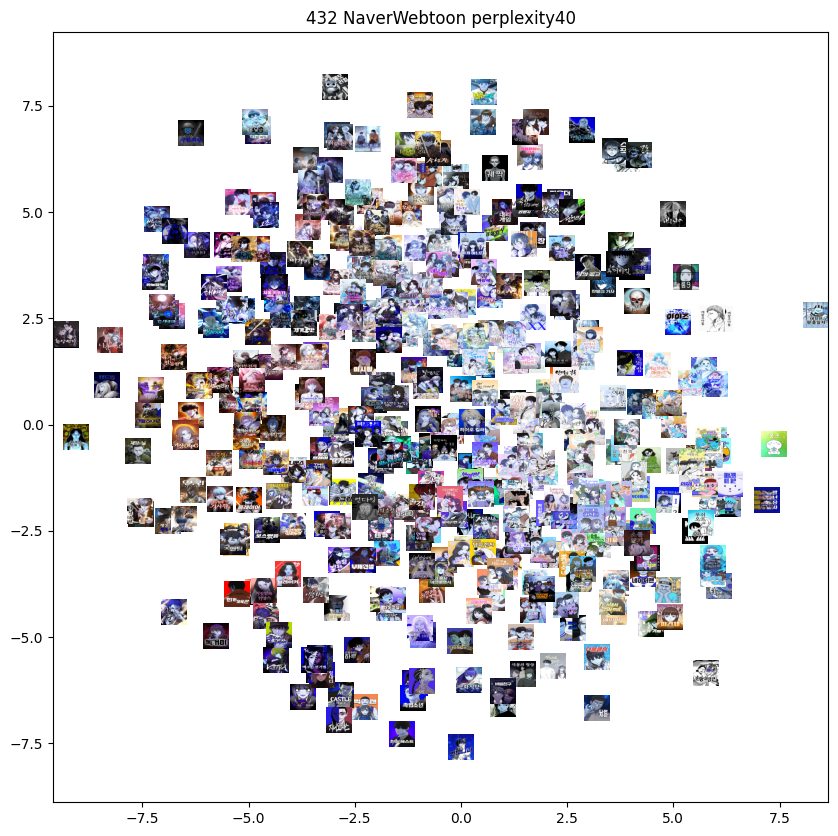

In [ ]:

fig, ax = plt.subplots(figsize=(10,10),nrows=1,ncols=1)

plt.xlim(features_tsne[:,0].min(),features_tsne[:,0].max()+1)
plt.ylim(features_tsne[:,1].min(),features_tsne[:,1].max()+1)


fig,axes=plt.subplots(2,3,figsize=(20,20))
for i in range(len(train)):




  img = train[i]


  x, y = features_tsne[i]
  ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), extent=(x-0.3, x+0.3, y-0.3, y+0.3))
plt.title('432 NaverWebtoon perplexity40')
plt.axis('equal')
plt.show()




- Kmeans ( K=5)

In [ ]:
from sklearn.cluster import KMeans

km=KMeans(n_clusters=5)

km.fit(features_tsne)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [ ]:
webtoon['집단']=km.labels_

In [ ]:
webtoon

,웹툰이름,썸네일경로,웹툰디테일경로,집단
0,뷰티풀 군바리,https://image-comic.pstatic.net/webtoon/648419...,https://comic.naver.com/webtoon/list?titleId=6...,0
1,신의 탑,https://image-comic.pstatic.net/webtoon/183559...,https://comic.naver.com/webtoon/list?titleId=1...,4
2,퀘스트지상주의,https://image-comic.pstatic.net/webtoon/783052...,https://comic.naver.com/webtoon/list?titleId=7...,2
3,똑 닮은 딸,https://image-comic.pstatic.net/webtoon/774866...,https://comic.naver.com/webtoon/list?titleId=7...,4
4,백수세끼,https://image-comic.pstatic.net/webtoon/733074...,https://comic.naver.com/webtoon/list?titleId=7...,1
...,...,...,...,...
426,"행운을 빌어요, 용사님!",https://image-comic.pstatic.net/webtoon/775334...,https://comic.naver.com/webtoon/list?titleId=7...,2
427,세라는 망돌,https://image-comic.pstatic.net/webtoon/802359...,https://comic.naver.com/webtoon/list?titleId=8...,4
428,기억해줘,https://image-comic.pstatic.net/webtoon/801699...,https://comic.naver.com/webtoon/list?titleId=8...,2
429,너에게 입덕중,https://image-comic.pstatic.net/webtoon/799226...,https://comic.naver.com/webtoon/list?titleId=7...,3


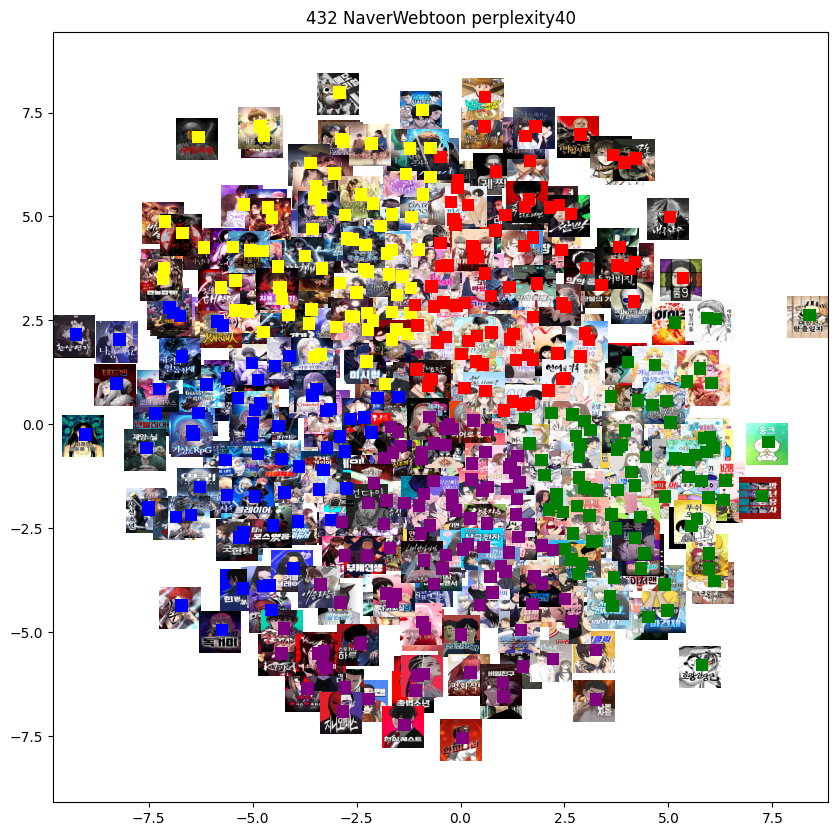

In [ ]:
import matplotlib.patches as patches
color=['blue','red','yellow','green','purple']
fig, ax = plt.subplots(figsize=(10,10),nrows=1,ncols=1)

plt.xlim(features_tsne[:,0].min(),features_tsne[:,0].max()+1)
plt.ylim(features_tsne[:,1].min(),features_tsne[:,1].max()+1)



for i in range(len(train)):

  img = train[i]


  x, y = features_tsne[i]
  rect = patches.Rectangle((x - 0.1, y - 0.1), 0.3, 0.3, facecolor=color[webtoon['집단'][i]])
  ax.add_patch(rect)
  ax.imshow(img, extent=(x-0.5, x+0.5, y-0.5, y+0.5))
#cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.title('432 NaverWebtoon perplexity40')
plt.axis('equal')
plt.show()







> ### 6. CSV 파일 생성

In [ ]:
d=pd.DataFrame(np.concatenate((features_tsne, km.labels_.reshape(431,1)), axis=1),columns=['x','y','군집'])
final=pd.concat([webtoon,d],axis=1)

In [ ]:
final.to_csv('/content/drive/MyDrive/webtoon0607.csv')

In [ ]:
final

,웹툰이름,썸네일경로,웹툰디테일경로,집단,x,y,군집
0,뷰티풀 군바리,https://image-comic.pstatic.net/webtoon/648419...,https://comic.naver.com/webtoon/list?titleId=6...,0,-2.954510,-0.343603,0.0
1,신의 탑,https://image-comic.pstatic.net/webtoon/183559...,https://comic.naver.com/webtoon/list?titleId=1...,4,1.115394,-1.090977,4.0
2,퀘스트지상주의,https://image-comic.pstatic.net/webtoon/783052...,https://comic.naver.com/webtoon/list?titleId=7...,2,-0.963525,7.515509,2.0
3,똑 닮은 딸,https://image-comic.pstatic.net/webtoon/774866...,https://comic.naver.com/webtoon/list?titleId=7...,4,-1.087795,-6.093816,4.0
4,백수세끼,https://image-comic.pstatic.net/webtoon/733074...,https://comic.naver.com/webtoon/list?titleId=7...,1,0.523472,7.113205,1.0
...,...,...,...,...,...,...,...
426,"행운을 빌어요, 용사님!",https://image-comic.pstatic.net/webtoon/775334...,https://comic.naver.com/webtoon/list?titleId=7...,2,-3.524579,5.676451,2.0
427,세라는 망돌,https://image-comic.pstatic.net/webtoon/802359...,https://comic.naver.com/webtoon/list?titleId=8...,4,-0.792894,0.133004,4.0
428,기억해줘,https://image-comic.pstatic.net/webtoon/801699...,https://comic.naver.com/webtoon/list?titleId=8...,2,-3.406768,5.108115,2.0
429,너에게 입덕중,https://image-comic.pstatic.net/webtoon/799226...,https://comic.naver.com/webtoon/list?titleId=7...,3,3.052385,-2.246902,3.0


In [ ]:
features_tsne.shape

(431, 2)